<a href="https://colab.research.google.com/github/JoachimGoedhart/DotBlot-analysis/blob/main/DotBlot_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dotblot Analysis

## Introduction

Levels of chemokines are measured through an array that produces a dotblot as result (https://www.rndsystems.com/products/proteome-profiler-human-cytokine-array-kit_ary005b). Every dot is linked to different antibodies, and quantification is necessary to get informative data out of it. Previously, dot blot quantification has typically been done manually. Thus, the goal is to automate this process by creating a pipeline of code in ‘Python’.

Therefore, the aim of this Jupyter Notebook is to automatize the process of registering each single dotblot to the mask, to get the grey value from each dot, and finally to arrange the values in a [tidy table](https://thenode.biologists.com/converting-excellent-spreadsheets-tidy-data/education/) to allow for a faster and easier analysis.

### How to use this Notebook

Before you run the Notebook, make sure that you are logged into your Google account and have the data to process in your Google Drive.

### Before Starting

For the code to work, Images must be 700x300 and in .tif format. This is best done in ImageJ before starting the analysis.

### Test Round Option

Before using your personal data, you can test this Notebook by running it, using example data that we provide on GitHub. In case any of these steps fail, please file an issue on GitHub.


### Step 1: Initialization 

Executing this section, by pressing the "play" button, will load all the required packages and data necessary for the proper functioning of this Notebook.

In [1]:
#@title Initialization
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#For ROI identification and Gray value quantification
from skimage import io
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
from skimage import filters as filt

#Install pystackreg and load
!pip install pystackreg
from pystackreg import StackReg
from skimage import util

#Loading external data
#Load mask
mask = io.imread("https://github.com/JoachimGoedhart/DotBlot-analysis/raw/main/Mask_v3-700x300.tif")
#Load Conditions files
url = 'https://raw.githubusercontent.com/JoachimGoedhart/DotBlot-analysis/main/Table_chemokine-array.csv'
conditions = pd.read_csv(url)
conditions.index += 1

#Define Directories
in_dir = "" 
out_dir = ""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Step 2: Mount Drive

To make this Notebook work, you need to mount the personal Drive to the GoogleCoLab. To do that, “Run” the code below and accept to access your Drive. Once this is done,if you click on the folder icon (on the left), your Drive folder should appear with all your personal organized Drive that you are able to access freely.

### Test Round Option

If you only want to test this Notebook, skip step 2 and 3, and proceed to the "Registration" section.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 3: Directories

Once you are connected to your personal Drive you can access the data. To make the workspace clear and neat the data is divided in folders (“directories”):

- In_dir = folder with the TIF files (700x300) of the dotblot that must be analysed
- Out_dir = folder where all the output files are going to end up (registered images in grayscale, and long format tables with grey values)

To give the right directions, go on the three dots next to the folder of interest and click on “Copy path”, then past this in the right correspondent directory.

In [ ]:
#@title Define the input and output Directories

in_dir = "" #@param {type:"string"}
out_dir = "" #@param {type:"string"}

if in_dir != "":
  filelist = os.listdir(in_dir)
  print("These files are detected in the directory:")
  print(filelist)

### Step 4: Registration, Quantification and Saving output Files

This loop will access the TIF files folder and consequently register, quantify, and design output tables for each one of the files. 
"Run" the code and check the output down below. 

https://github.com/JoachimGoedhart/DotBlot-analysis/raw/main/Dotblot_Example-data_overlay.tif


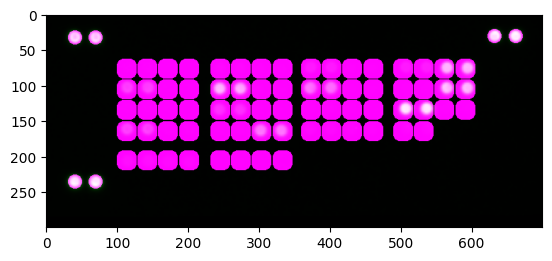

   Coordinates                       Condition  area  mean intensity
1           A1                 Reference Spots   316      153.088608
2           A2                 Reference Spots   316      157.784810
3          A19                 Reference Spots   316      146.743671
4          A20                 Reference Spots   316      145.297468
5           B3                          6Ckine   700        2.645714
..         ...                             ...   ...             ...
72          F8  Transferrin R (Sample Control)   700        2.142857
73          F9                Negative Control   700        1.708571
74         F10                Negative Control   700        1.691429
75          G1                 Reference Spots   316      158.563291
76          G2                 Reference Spots   316      163.012658

[76 rows x 4 columns]


In [2]:
#Remove the middle dots from the mask - we only use the outer dots for registration
#Suggested by Nico Schramma
center = [50,220,100,650] #x1,x2,y1,y2

mask_no_center = mask.copy()
mask_no_center[center[0]:center[1],center[2]:center[3]] = 0


#ROI from mask 
dots = clear_border(mask)

# The scikit-image module 'skimage.filters.thresholding' provides
# several threshold detection algorithms. The most popular one 
# among them is Otsu's method.
threshold = threshold_otsu(dots)
binary_dots = dots > threshold

#Connected component labeling
labeled_image = label(dots)

num_labels = np.max(labeled_image)

#Create a table with label values and pixel counts 
labels_table = np.zeros((num_labels,2))
for i in range(num_labels):
    labels_table[i,0]=i+1
    labels_table[i,1]=np.sum(labeled_image == i+1)

#Loop accessing subdirectory (TIF_files)
#Registration images
#Quantification of Gray value 
#Saving the output as .csv files in new subdirectory

counter = 1
sr = StackReg(StackReg.AFFINE)


if in_dir == "":
    filelist = ["https://github.com/JoachimGoedhart/DotBlot-analysis/raw/main/Dotblot_Example-data.tif"]
else:
    filelist = os.listdir(in_dir)

for file in filelist:
    if in_dir == "":
        img = io.imread('https://github.com/JoachimGoedhart/DotBlot-analysis/raw/main/Dotblot_Example-data.tif')
    else: 
      img = io.imread(in_dir+'/'+file)

    #Remove the middle dots from the data - we only use the outer dots for registration
    #Suggested by Nico Schramma
    img_no_center = img.copy()
    img_no_center[center[0]:center[1],center[2]:center[3]] = 0 
    thresh = filt.threshold_otsu(img_no_center)
    img_no_center[img_no_center<thresh] = 0
    img_no_center[img_no_center>=thresh] = 255

    #Calculate the tranformation matrix and apply it to the actual image
    tmat = sr.register(mask_no_center,img_no_center)
    i_reg = sr.transform(img,tmat)

    # Scale pixel values to the range [0, 1]
    reg_scaled = i_reg / i_reg.max()
    # Scale pixel values to the range [0, 255] and cast to uint8
    reg_scaledimg = util.img_as_ubyte(reg_scaled) #save it (it's a np array)
    grayscale_img = file.replace('.tif', '_overlay.tif')
    counter +=1
    if out_dir == "":
        print(grayscale_img)
    else:
        filepath = os.path.join(out_dir, grayscale_img)
        io.imsave(filepath, reg_scaledimg)
    #Convert 3D array to RGB and plot it
    condition_rgb = np.dstack((mask,reg_scaledimg,mask))
    #plt.subplot(1,2,1)
    plt.imshow(condition_rgb)
    plt.show()

    #Read the intensity image
    intensity_image = reg_scaledimg
    
    #Convert the intensity image to a single-layer image
    if intensity_image.ndim == 3:
        intensity_image = intensity_image[:,:,0]
    
    #labeled image = mask; intensity image = reference image
    properties = regionprops(labeled_image, intensity_image=intensity_image)

    statistics = {
        'area': [p.area for p in properties],
        'mean intensity': [p.mean_intensity for p in properties]
    }
    table = pd.DataFrame(statistics)
    table.index += 1  # start index from 1
    
    final_table = pd.concat([conditions, table], axis=1)
    final_table = final_table.drop('Label', axis=1)

    # create a unique output file name for this dataframe
    csv_file = file.replace('.tif', '.csv')
    # save the Dataframe to the csv_file in another directory ('output_files/')
    if out_dir == "":
        print(final_table)
    else:
        final_table.to_csv(out_dir+'/'+csv_file, index=True)
    
        #Print a message to confirm that the file was saved
        print(f" Table saved sucessfully as {csv_file}!")

In [ ]:
#@title Loading packages that are needed for dataViz using R

#!pip install rpy2==3.5.1

# activate R magic
#%load_ext rpy2.ipython

#%R install.packages('tidyverse')
#%R library(tidyverse)